# Acoustic Feature Selection
This notebook presents a demonstration of performance improvement by using the the implementated feature selection algorithms proposed by Ferreira, A., Figueiredo, M. (2012), on acoustic features extrated via OpenSMILE.
1. Algorithm 1: Relevance-only feature selection
- Dispersion measures: MAD, MM, TV, AMGM
2. Algorithm 2: Relevance-redundancy feature selection
- Similarity measures: AC, CC, MICI
3. Default parameters are set to the paper recommendations
4. Example usage is provided at the end of the script

References: Artur J. Ferreira and MáRio A. T. Figueiredo. 2012.  Efficient feature selection filters for high-dimensional data. 
Pattern Recogn. Lett. 33, 13 (October, 2012), 1794–1804. https://doi.org/10.1016/j.patrec.2012.05.019

## Load data and extract features with OpenSMILE

In [1]:
import kagglehub
import opensmile
import os

# Download latest version
path = kagglehub.dataset_download("piyushagni5/berlin-database-of-emotional-speech-emodb")
print("Path to dataset files:", path)

# Get list of files
files = [file_path.name for file_path in os.scandir(path+"/wav") if file_path.is_file()]

# Load data and extract features
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.GeMAPSv01b,
    feature_level=opensmile.FeatureLevel.Functionals,
)

feats_df = smile.process_files([path+"/wav/"+file for file in files])



/Users/sofiafernandes/miniconda3/envs/varm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/sofiafernandes/.cache/kagglehub/datasets/piyushagni5/berlin-database-of-emotional-speech-emodb/versions/1


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import seaborn as sns
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Load emoDB transcipts and labels
emo_db = pd.read_csv("emo_db_transcripts.csv")
X = feats_df.values
y = emo_db.label.values

# Split data
X = feats_df.values
y = emo_db.label.values
emotions = emo_db.label.unique()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Split data into train (64%), validation (16%) and test (20%)
#X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=6)

## Feature Selector

In [60]:
from sklearn.base import BaseEstimator, TransformerMixin
from select_features import algorithm1, algorithm2
import matplotlib.pyplot as plt
import numpy as np

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, algorithm='algorithm2', L=0.95, MS=0.8, dispersion_measure='MM'):
        self.algorithm = algorithm
        self.L = L
        self.MS = MS
        self.dispersion_measure = dispersion_measure
        self.selected_indices = None
        
    def fit(self, X, y=None):
        if self.algorithm == 'algorithm1':
            self.selected_indices = algorithm1(X, self.L, self.dispersion_measure)
        else:
            self.selected_indices = algorithm2(X, self.L, self.MS, self.dispersion_measure)
        return self
    
    def transform(self, X):
        return X[:, self.selected_indices]
    
# Visualizar máscara como imagem 2D
def plot_feature_mask(mask, title):
    # Calcular dimensões para visualização
    n_features = mask.shape[0]
    grid_size = int(np.ceil(np.sqrt(n_features)))
    pad = grid_size**2 - n_features
    
    # Aplicar padding e remodelar
    mask_padded = np.pad(mask, (0, pad))
    plt.imshow(mask_padded.reshape(grid_size, grid_size), cmap='gray')
    plt.title(title)
    plt.show()


## Baseline SVM

In [61]:
# Simple SVM classifier
clf_baseline = svm.SVC(kernel='linear')
clf_baseline.fit(X_train, y_train)
base_pred = clf_baseline.predict(X_test)
print(classification_report(y_test, base_pred, target_names=emotions))

              precision    recall  f1-score   support

     boredom       0.78      0.76      0.77        33
       anger       0.71      0.67      0.69        18
        fear       0.46      0.86      0.60         7
     disgust       0.60      0.53      0.56        17
     neutral       0.44      0.47      0.45        15
   happiness       0.12      0.12      0.12         8
     sadness       1.00      0.67      0.80         9

    accuracy                           0.62       107
   macro avg       0.59      0.58      0.57       107
weighted avg       0.64      0.62      0.62       107



# Comparison using Feature Selection

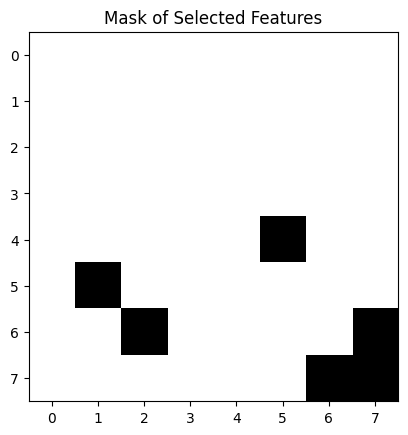

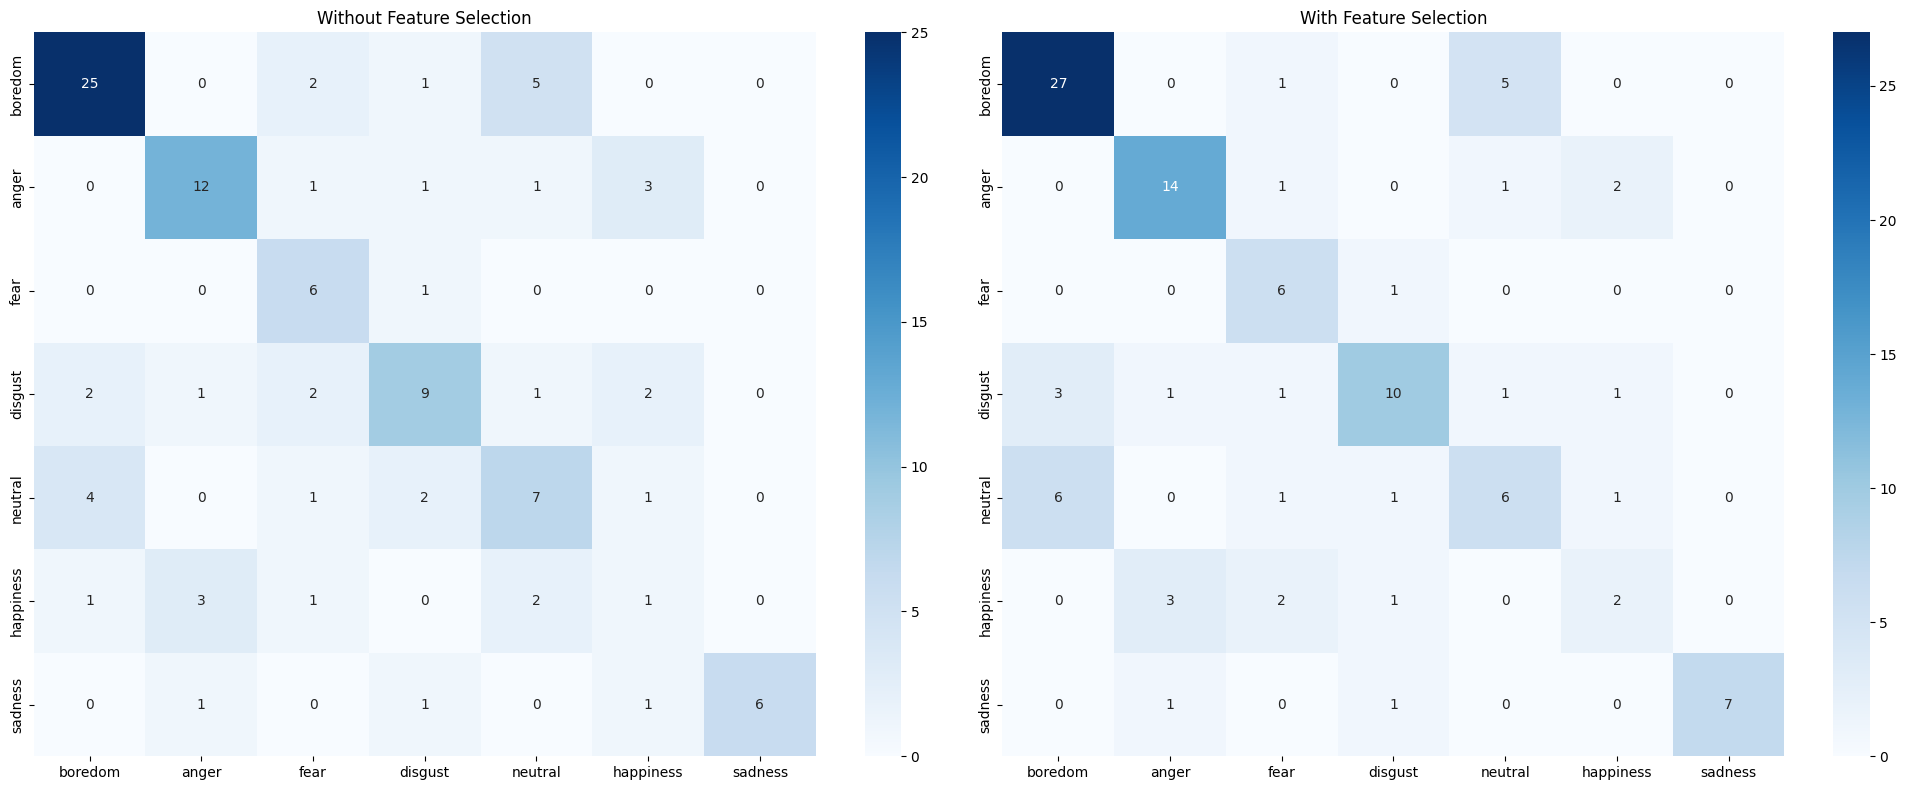


Performance without feature selection:
              precision    recall  f1-score   support

     boredom       0.78      0.76      0.77        33
       anger       0.71      0.67      0.69        18
        fear       0.46      0.86      0.60         7
     disgust       0.60      0.53      0.56        17
     neutral       0.44      0.47      0.45        15
   happiness       0.12      0.12      0.12         8
     sadness       1.00      0.67      0.80         9

    accuracy                           0.62       107
   macro avg       0.59      0.58      0.57       107
weighted avg       0.64      0.62      0.62       107


Performance with feature selection:
              precision    recall  f1-score   support

     boredom       0.75      0.82      0.78        33
       anger       0.74      0.78      0.76        18
        fear       0.50      0.86      0.63         7
     disgust       0.71      0.59      0.65        17
     neutral       0.46      0.40      0.43        15
 

In [62]:
# Feature selector
selector = FeatureSelector(algorithm='algorithm1', L=0.95)
selector.fit(X_train)

# Plot mask
n_total_features = X_train.shape[1]
mask = np.zeros(n_total_features)
mask[selector.selected_indices] = 1
plot_feature_mask(mask, 'Mask of Selected Features')

# Apply selection (Algorthm 1)
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

# Normalize features
scaler = StandardScaler()
X_train_sel = scaler.fit_transform(X_train_sel)
X_test_sel = scaler.transform(X_test_sel)

# Apply selection (Algorthm 2)
selector = FeatureSelector(algorithm='algorithm2', L=0.95, MS=0.2)
selector.fit(X_train_sel)
X_train_sel = selector.transform(X_train_sel)
X_test_sel = selector.transform(X_test_sel)

# Train classifier with selected features
clf_selected = svm.SVC(kernel='linear')
clf_selected.fit(X_train_sel, y_train)
sel_pred = clf_selected.predict(X_test_sel)

# Comparison
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(confusion_matrix(y_test, base_pred), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=emotions,
            yticklabels=emotions,
            ax=ax[0])
ax[0].set_title('Without Feature Selection')
sns.heatmap(confusion_matrix(y_test, sel_pred), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=emotions,
            yticklabels=emotions,
            ax=ax[1])
ax[1].set_title('With Feature Selection')
plt.tight_layout()
plt.show()

print("\nPerformance without feature selection:")
print(classification_report(y_test, base_pred, target_names=emotions))
print("\nPerformance with feature selection:")
print(classification_report(y_test, sel_pred, target_names=emotions))

# Métricas comparativas
print("\nFinal Comparison:")
print(f"Baseline Accuracy: {accuracy_score(y_test, base_pred):.2%}")
print(f"Baseline w/ Selection Accuracy: {accuracy_score(y_test, sel_pred):.2%}")
print(f"Reduced Features: {len(selector.selected_indices)}/{n_total_features}")

# Other Classifiers

In [59]:




# Aplicar seleção de características
selector = FeatureSelector(algorithm='algorithm2', L=0.95, MS=0.8)
selector.fit(X_train)

X_train_sel = selector.transform(X_train)
X_val_sel = selector.transform(X_val)
X_test_sel = selector.transform(X_test)

print(f"Selecionadas {len(selector.selected_indices)} características:")
print(feats_df.columns[selector.selected_indices])

# Treinar e avaliar modelo
clf = svm.SVC(kernel='linear', random_state=42)
clf.fit(X_train_sel, y_train)

# Avaliar na validação
val_pred = clf.predict(X_val_sel)
print("\nRelatório de Classificação (Validação):")
print(classification_report(y_val, val_pred, target_names=emotions.values()))

# Avaliação final no teste
test_pred = clf.predict(X_test_sel)
print("\nRelatório de Classificação Final (Teste):")
print(classification_report(y_test, test_pred, target_names=emotions.values()))

# Matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, test_pred), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=emotions.values(), 
            yticklabels=emotions.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix com Seleção de Características')
plt.show()

Selecionadas 21 características:
Index(['F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope',
       'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope',
       'F1frequency_sma3nz_amean', 'slopeV500-1500_sma3nz_stddevNorm',
       'F0semitoneFrom27.5Hz_sma3nz_percentile80.0',
       'slopeV0-500_sma3nz_stddevNorm', 'logRelF0-H1-H2_sma3nz_stddevNorm',
       'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2',
       'logRelF0-H1-A3_sma3nz_stddevNorm', 'jitterLocal_sma3nz_stddevNorm',
       'alphaRatioV_sma3nz_stddevNorm', 'hammarbergIndexV_sma3nz_amean',
       'StddevUnvoicedSegmentLength', 'hammarbergIndexV_sma3nz_stddevNorm',
       'MeanUnvoicedSegmentLength', 'F2amplitudeLogRelF0_sma3nz_stddevNorm',
       'slopeV0-500_sma3nz_amean', 'jitterLocal_sma3nz_amean',
       'slopeUV0-500_sma3nz_amean', 'F2frequency_sma3nz_stddevNorm',
       'slopeV500-1500_sma3nz_amean'],
      dtype='object')

Relatório de Classificação (Validação):


AttributeError: 'numpy.ndarray' object has no attribute 'values'